In [ ]:
!pip install pandas matplotlib seaborn natasha scikit-learn evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import evaluate
import torch
import re

##Загрузка данных

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/data/raw/train.csv'

try:
    df = pd.read_csv(file_path)
    print("Файл успешно загружен!")
except:
    df = pd.read_csv(file_path, sep=';')
    print("Файл загружен с разделителем ';'")

print(f"Размер датасета: {df.shape}")
display(df.head())

Файл успешно загружен!
Размер датасета: (232366, 4)


,ID,text,src,label
0,26739,smaller than in description.,rureviews,0
1,198426,Слева от меня Алексей Ильмухин. Путешественник...,rusentiment,1
2,172615,"Ребёнок в садик отходил год, из них пол года п...",geo,2
3,246532,Замерзла на -15,perekrestok,2
4,209852,"Как всегда, название не соответствует истинном...",kinopoisk,0


In [ ]:
df_clean = df[['text', 'label']].copy()

In [ ]:
df_clean = df_clean.dropna(subset=['text'])
df_clean['label'] = df_clean['label'].astype(int) # Убеждаемся, что инты

print(f"Размер датасета: {len(df_clean)}")
print(df_clean.head())

Размер датасета: 232366
                                                text  label
0                       smaller than in description.      0
1  Слева от меня Алексей Ильмухин. Путешественник...      1
2  Ребёнок в садик отходил год, из них пол года п...      2
3                                    Замерзла на -15      2
4  Как всегда, название не соответствует истинном...      0


<Axes: >

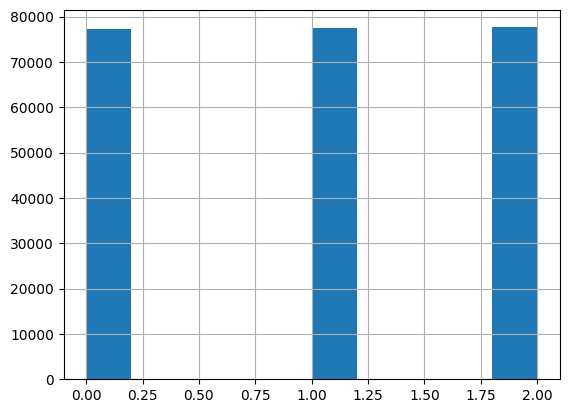

In [ ]:
df['label'].hist()

##Разбиение и создание датасета

In [ ]:
train_df, val_df = train_test_split(
    df_clean, test_size=0.1, random_state=42, stratify=df_clean['label']
)

In [ ]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(val_df)
})

##Создание и настройка модели ruBert-tiny

In [ ]:
model_baseline = "seara/rubert-tiny2-russian-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_baseline)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

tokenized_datasets = dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(model_baseline)

Map:   0%|          | 0/197511 [00:00<?, ? examples/s]

Map:   0%|          | 0/34855 [00:00<?, ? examples/s]

In [ ]:
for param in model.bert.parameters():
    param.requires_grad = False

In [ ]:
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    # Считаем macro F1 по ТЗ
    return f1_metric.compute(predictions=predictions, references=labels, average="macro")


In [ ]:
training_args = TrainingArguments(
    output_dir="checkpoints",
    learning_rate=1e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

#Обучение и валидация модели


##seara/rubert-tiny2-russian-sentiment

In [ ]:
print("\nНачинаем обучение (только голова)")
trainer.train()


Начинаем обучение (только голова)


Epoch,Training Loss,Validation Loss,F1
1,0.683300,0.658077,0.703765
2,0.686000,0.657541,0.702853
3,0.680100,0.654968,0.705241
4,0.679300,0.655331,0.702590
5,0.681700,0.654706,0.704404


TrainOutput(global_step=30865, training_loss=0.6834493849973865, metrics={'train_runtime': 1584.3493, 'train_samples_per_second': 623.319, 'train_steps_per_second': 19.481, 'total_flos': 4299378597414324.0, 'train_loss': 0.6834493849973865, 'epoch': 5.0})

In [ ]:
print("\nСчитаем итоговые метрики на валидации")
eval_result = trainer.evaluate()
print(f"Baseline Macro-F1: {eval_result['eval_f1']:.4f}")


Считаем итоговые метрики на валидации


Baseline Macro-F1: 0.7052


F1-macro на валидации: 0.7052

###Сохранение модели

In [ ]:
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/seara")
tokenizer.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/seara")

('/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/seara/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/seara/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/seara/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/seara/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/seara/tokenizer.json')

##cointegrated/rubert-tiny2

In [ ]:
model_cointegrated = "cointegrated/rubert-tiny2"
tokenizer_cointegrated = AutoTokenizer.from_pretrained(model_cointegrated)

# ИНИЦИАЛИЗИРУЕМ МОДЕЛЬ ПОД 3 КЛАССА
id2label = {0: "neutral", 1: "positive", 2: "negative"}
label2id = {"neutral": 0, "positive": 1, "negative": 2}

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def preprocess_function_cointegrated(examples):
    return tokenizer_cointegrated(examples["text"], truncation=True, max_length=512)

tokenized_datasets_cointegrated = dataset.map(preprocess_function_cointegrated, batched=True)
data_collator_cointegrated = DataCollatorWithPadding(tokenizer=tokenizer_cointegrated)

Map:   0%|          | 0/197511 [00:00<?, ? examples/s]

Map:   0%|          | 0/34855 [00:00<?, ? examples/s]

In [ ]:
model_cointegrated = AutoModelForSequenceClassification.from_pretrained(
    model_cointegrated,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args_cointegrated = TrainingArguments(
    output_dir="checkpoints_full_finetune",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    report_to="none"
)

In [ ]:
trainer_cointegrated = Trainer(
    model=model_cointegrated,
    args=training_args_cointegrated,
    train_dataset=tokenized_datasets_cointegrated["train"],
    eval_dataset=tokenized_datasets_cointegrated["test"],
    processing_class=tokenizer_cointegrated,
    data_collator=data_collator_cointegrated,
    compute_metrics=compute_metrics,
)

###Обучение и валидация модели

In [ ]:
print("\nНачинаем ПОЛНОЕ обучение (Full Fine-Tuning)")
trainer_cointegrated.train()


Начинаем ПОЛНОЕ обучение (Full Fine-Tuning)


Epoch,Training Loss,Validation Loss,F1
1,0.629300,0.609689,0.721569
2,0.585200,0.588541,0.736271
3,0.561200,0.586933,0.736347


TrainOutput(global_step=9261, training_loss=0.6151384428399336, metrics={'train_runtime': 2400.6043, 'train_samples_per_second': 246.827, 'train_steps_per_second': 3.858, 'total_flos': 2776897094103396.0, 'train_loss': 0.6151384428399336, 'epoch': 3.0})

In [ ]:
print("\nСчитаем итоговые метрики на валидации")
eval_result_cointegrated = trainer_cointegrated.evaluate()
print(f"Baseline Macro-F1: {eval_result_cointegrated['eval_f1']:.4f}")


Считаем итоговые метрики на валидации


Baseline Macro-F1: 0.7363


F1-macro на валидации: 0.7363

###Сохранение модели

In [ ]:
trainer_cointegrated.save_model("/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated")
tokenizer_cointegrated.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated")

('/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/cointegrated/tokenizer.json')

#Создание, настройка и обучение ai-forever/ruBert-base

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Убираем переносы строк и табуляции
    text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', '')
    # Убираем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [ ]:
df['text'] = df['text'].apply(clean_text)

df = df[df['text'].str.len() > 0]

In [ ]:
id2label = {0: "neutral", 1: "positive", 2: "negative"}
label2id = {"neutral": 0, "positive": 1, "negative": 2}

train_df_base, val_df_base = train_test_split(
    df, test_size=0.1, random_state=42, stratify=df['label']
)

dataset_base = DatasetDict({
    "train": Dataset.from_pandas(train_df_base),
    "test": Dataset.from_pandas(val_df_base)
})

print(f"Train size: {len(train_df_base)}, Val size: {len(val_df_base)}")

Train size: 209128, Val size: 23237


In [ ]:
model_checkpoint_base = "ai-forever/ruBert-base"
tokenizer_base = AutoTokenizer.from_pretrained(model_checkpoint_base)

def preprocess_function_base(examples):
    return tokenizer_base(
        examples["text"],
        truncation=True,
        max_length=512
    )

print("Tokenizing dataset...")
tokenized_datasets_base = dataset_base.map(preprocess_function_base, batched=True)
data_collator_base = DataCollatorWithPadding(tokenizer=tokenizer_base)

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Tokenizing dataset...


Map:   0%|          | 0/209128 [00:00<?, ? examples/s]

Map:   0%|          | 0/23237 [00:00<?, ? examples/s]

In [ ]:
model_base = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint_base,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
f1_metric = evaluate.load("f1")

def compute_metrics_base(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [ ]:
for param in model_base.bert.parameters():
    param.requires_grad = False

for i in range(9, 12):
    for param in model_base.bert.encoder.layer[i].parameters():
        param.requires_grad = True

if model_base.bert.pooler:
    for param in model_base.bert.pooler.parameters():
        param.requires_grad = True

for param in model_base.classifier.parameters():
    param.requires_grad = True


In [ ]:
training_args_base = TrainingArguments(
    output_dir="rubert_base_finetuned_checkpoints",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    num_train_epochs=3,
    fp16=True,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    report_to="none"
)

trainer_base = Trainer(
    model=model_base,
    args=training_args_base,
    train_dataset=tokenized_datasets_base["train"],
    eval_dataset=tokenized_datasets_base["test"],
    processing_class=tokenizer_base,
    data_collator=data_collator_base,
    compute_metrics=compute_metrics_base,
)


In [ ]:
trainer_base.train()

Epoch,Training Loss,Validation Loss,F1
1,0.548900,0.539549,0.762951
2,0.515900,0.516753,0.772689
3,0.470100,0.520041,0.775296


TrainOutput(global_step=19608, training_loss=0.5247265126256736, metrics={'train_runtime': 4759.8883, 'train_samples_per_second': 131.806, 'train_steps_per_second': 4.119, 'total_flos': 9.707557624747819e+16, 'train_loss': 0.5247265126256736, 'epoch': 3.0})

In [ ]:
metrics = trainer_base.evaluate()
print(f" MACRO-F1: {metrics['eval_f1']:.4f} \n")

 MACRO-F1: 0.7753 



F1-macro на валидации: 0.775

In [ ]:
trainer_base.save_model("/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/base")
tokenizer_base.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/base")

('/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/base/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/base/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/base/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/base/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/Hack_28-11-2025/models/base/tokenizer.json')